# Whatprot datasets

In this notebook we will test results from datasets created with whatprot and then exported to GPU format. This decision of changing the generation was because the simulation through erisyon was not working both for simulation and classifier generation, and we did not have control of the steps. With whatprot we can generate with our own computer the simulations, at least for the oracle.

In [25]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import re

results_path="/home/jkipen/ProtInfGPU/results/"
opt_prot_inf="./../code/cuda/opt.out" 

In [23]:
##Common functions
def ret_config(config_path, key):
    with open(config_path, "r") as file:
        for line in file:
            if line.startswith(key + ":"):
                return line.split(":")[1].strip()  # Get the value after ':' and remove spaces
    return None  # Return None if the key is not found
def get_data_from_experiment_oracle_perr(exp_path): #Gets the data to compare oracle p_errs!
    df=pd.read_csv(exp_path+'/ErrVsEpochs.csv')
    df_numpy=df.to_numpy()
    x=df_numpy[:,0]; y=df_numpy[:,1];  y_err=df_numpy[:,2]/2
    p_err=ret_config(exp_path+"/RunConfig.txt","Oracle Perr")
    return x,y,y_err,p_err

def get_data_from_experiment_oracle_perr(exp_path): #Gets the data to compare oracle p_errs!
    df=pd.read_csv(exp_path+'/ErrVsEpochs.csv')
    df_numpy=df.to_numpy()
    x=df_numpy[:,0]; y=df_numpy[:,1];  y_err=df_numpy[:,2]/2
    p_err=ret_config(exp_path+"/RunConfig.txt","Oracle Perr")
    return x,y,y_err,p_err

def get_data_from_experiment_oracle_subset(exp_path):
    df=pd.read_csv(exp_path+'/ErrVsEpochs.csv')
    df_numpy=df.to_numpy()
    x=df_numpy[:,0]; y=df_numpy[:,1];  y_err=df_numpy[:,2]/2
    n_subset=ret_config(exp_path+"/RunConfig.txt","NsubsetCV")
    return x,y,y_err,n_subset

def get_eq_guess(n_prot,n_dists_est=1000):
    exponential_vars = np.random.exponential(size=(n_dists_est, n_prot))
    random_dists = exponential_vars / exponential_vars.sum(axis=1, keepdims=True)
    equidis_err = np.mean(np.mean(np.abs(random_dists-np.ones(shape=(n_dists_est,n_prot))/n_prot),axis=1))
    return equidis_err

def compare_oracle_dif_errs(n_prot,log=True):
    out_path=results_path+"/"+str(n_prot)+"_Prot/Oracle_dif_errs/";
    plt.figure()
    plt.ylabel("MAE")
    plt.xlabel("N Epochs")
    xs=[];ys=[];y_errs=[];p_errs=[];
    with os.scandir(out_path) as entries:
        for entry in entries:
            if entry.is_dir() and re.match(r"^\d", entry.name):  # Only consider directories that starts with numbers
                x,y,y_err,p_err=get_data_from_experiment_oracle_perr(os.path.join(out_path, entry.name))
                xs.append(x);ys.append(y);y_errs.append(y_err);p_errs.append(float(p_err));
                #plt.errorbar(x, y,  yerr=y_err, label= "Oracle p=" + p_err)

    sorted_data = sorted(zip(p_errs, xs, ys, y_errs), key=lambda t: t[0])  
    p_errs, xs, ys, y_errs = zip(*sorted_data)  # Unpack sorted data

    for x, y, y_err, p_err in zip(xs, ys, y_errs, p_errs):
        plt.errorbar(x, y, yerr=y_err, label=f"Oracle p={p_err}")
    equidis_err=get_eq_guess(n_prot)
    plt.axhline(y=equidis_err, color='red', linestyle='dotted', label=f'Equidistributed Error = {equidis_err:.5f}')

    plt.legend()
    plt.title("Oracle perr comp")
    if log:
        plt.yscale('log')
    plt.grid()
    #plt.ylim([0, 0.005])
    plt.show()
    
def compare_oracle_subsets(n_prot,log=True):
    out_path=results_path+"/"+str(n_prot)+"_Prot/Oracle_subsets/";
    plt.figure()
    plt.ylabel("MAE")
    plt.xlabel("N Epochs")
    xs=[];ys=[];y_errs=[];n_subsets=[];
    with os.scandir(out_path) as entries:
        for entry in entries:
            if entry.is_dir() and re.match(r"^\d", entry.name):  # Only consider directories that starts with numbers
                x,y,y_err,n_subset=get_data_from_experiment_oracle_subset(os.path.join(out_path, entry.name))
                xs.append(x);ys.append(y);y_errs.append(y_err);n_subsets.append(float(n_subset));
                #plt.errorbar(x, y,  yerr=y_err, label= "Oracle p=" + p_err)

    sorted_data = sorted(zip(n_subsets, xs, ys, y_errs), key=lambda t: t[0])  
    n_subsets, xs, ys, y_errs = zip(*sorted_data)  # Unpack sorted data

    for x, y, y_err, n_subset in zip(xs, ys, y_errs, n_subsets):
        plt.errorbar(x, y, yerr=y_err, label="Oracle "+ "{:.2E}".format(n_subset) +"samples")
    equidis_err=get_eq_guess(n_prot)
    plt.axhline(y=equidis_err, color='red', linestyle='dotted', label=f'Equidistributed Error = {equidis_err:.5f}')

    plt.legend()
    plt.title("Oracle perr comp")
    if log:
        plt.yscale('log')
    plt.grid()
    #plt.ylim([0, 0.005])
    plt.show()

# 50 Prot


In [26]:
#Parameters we will tune
n_epochs=60;
subset=500000;
oracle_err=0;
cv_runs=10;
in_path= "/home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle"
out_path= "/home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs"

In [27]:
oracle_errs=[0,0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]
for oracle_err in oracle_errs:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 
    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.01
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.05
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.1
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_dif_errs -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0.2
./../code/cuda/opt.o

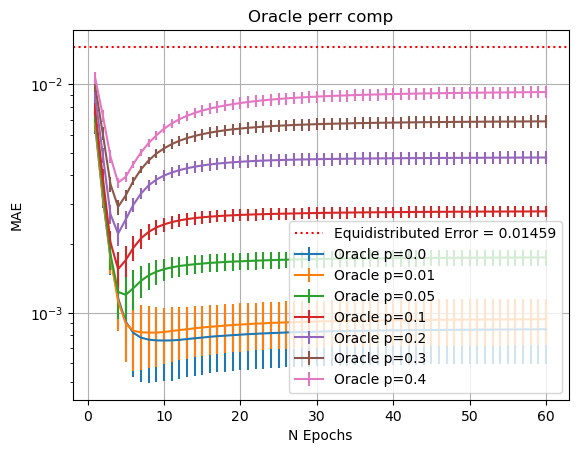

In [29]:
compare_oracle_dif_errs(50)

In [30]:
out_path= "/home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets"
oracle_err=0;
subsets=[50000,100000,250000,500000,750000,1000000]
for subset in subsets:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 

    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 50000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 100000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 250000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/50_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/50_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 750000 -t 128 -o 0
./../code/cuda/opt.out /home/jkipen/

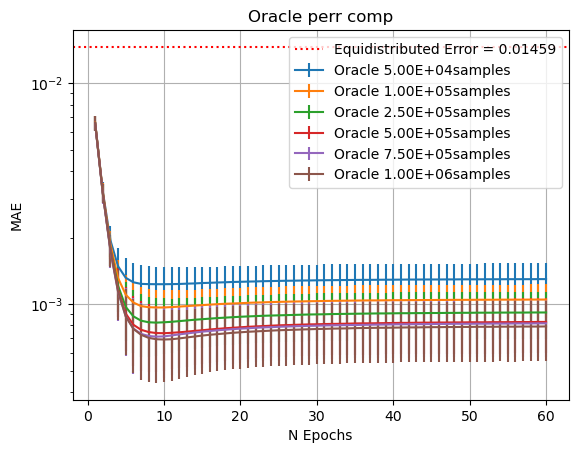

In [31]:
compare_oracle_subsets(50)

# 1000 Prot


In [32]:
#Parameters we will tune
n_epochs=60;
subset=500000;
oracle_err=0;
cv_runs=10;
in_path= "/home/jkipen/raid_storage/ProtInfGPU/data/1000_Prot/binary/Oracle"
out_path= "/home/jkipen/ProtInfGPU/results/1000_Prot/Oracle_dif_errs"

In [39]:
out_path= "/home/jkipen/ProtInfGPU/results/1000_Prot/Oracle_subsets"
oracle_err=0;
#subsets=[50000,100000,250000,500000,750000,1000000,2000000,5000000,10000000]
subsets=[10000000]
for subset in subsets:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 

    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/1000_Prot/binary/Oracle /home/jkipen/ProtInfGPU/results/1000_Prot/Oracle_subsets -d 3 -e 60 -c 10 -m 50 -M 30 -s 10000000 -t 128 -o 0


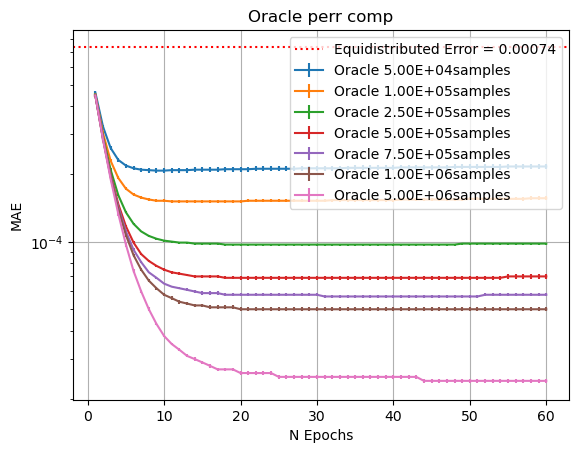

In [38]:
compare_oracle_subsets(1000)

In [ ]:
subset=1000000;
oracle_errs=[0,0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]
for oracle_err in oracle_errs:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 
    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    print(command)
    os.system(command)

In [ ]:
compare_oracle_dif_errs(1000)